In [1]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import albumentations as Album

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models.segmentation as segmentation
import torchvision.transforms as T

In [2]:
imgDir  = 'D:/VisionExtraction/val2017'
annFile = 'D:/VisionExtraction/annotations/instances_val2017.json'

In [3]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


In [4]:
bear_catId = coco.getCatIds(catNms=["bear"])[0]

In [5]:
bear_imgIds = coco.getImgIds(catIds=[bear_catId])
random.shuffle(bear_imgIds)

In [6]:
sample_imgIds = bear_imgIds[:5]

In [7]:
class CocoBearDataset(Dataset):
    def __init__(self, coco, imgDir, imgIds, catId, transform=None):
        self.coco = coco
        self.imgDir = imgDir
        self.imgIds = imgIds
        self.catId = catId
        self.transform = transform

    def __len__(self):
        return len(self.imgIds)

    def __getitem__(self, idx):
        imgId = self.imgIds[idx]
        imgInfo = self.coco.loadImgs(imgId)[0]

        # Load image
        imgPath = os.path.join(self.imgDir, imgInfo['file_name'])
        image = cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2RGB)

        # Load mask (bear=1, background=0)
        annIds = self.coco.getAnnIds(imgIds=imgInfo['id'], catIds=[self.catId])
        anns = self.coco.loadAnns(annIds)
        mask = np.zeros((imgInfo['height'], imgInfo['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann).astype(np.uint8))

        # Resize
        image = cv2.resize(image, (255, 255))
        mask = cv2.resize(mask, (255, 255), interpolation=cv2.INTER_NEAREST)

        # Albumentations augmentation
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Convert to tensor
        image = T.ToTensor()(image)  # [C,H,W] float32
        mask = torch.tensor(mask, dtype=torch.long)  # [H,W] long

        return image, mask

In [8]:
split = int(0.8 * len(bear_imgIds))
train_ids, val_ids = bear_imgIds[:split], bear_imgIds[split:]

In [9]:
train_transform = Album.Compose([
    Album.Resize(255, 255),
    Album.RandomRotate90(),
    Album.HorizontalFlip(p=0.5),
    Album.VerticalFlip(p=0.5),
    Album.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=60, p=0.7),
    Album.RandomBrightnessContrast(p=0.5),
    Album.HueSaturationValue(p=0.5),
    Album.GaussianBlur(blur_limit=(3, 7), p=0.4),
    Album.RandomGamma(p=0.4),
    Album.CoarseDropout(max_holes=8, max_height=40, max_width=40, p=0.3)
])


C:\Users\Admin\anaconda3\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1181111118.py:11: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  Album.CoarseDropout(max_holes=8, max_height=40, max_width=40, p=0.3)


In [10]:
val_transform = Album.Compose([
    Album.Resize(255, 255)
])

In [11]:
train_dataset = CocoBearDataset(coco, imgDir, train_ids, bear_catId, transform=train_transform)
val_dataset   = CocoBearDataset(coco, imgDir, val_ids,   bear_catId, transform=val_transform)


In [12]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = segmentation.deeplabv3_resnet50(pretrained=True)
num_classes = 2
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 0.6799
Epoch 2/5, Loss: 0.4994
Epoch 3/5, Loss: 0.3658
Epoch 4/5, Loss: 0.3462
Epoch 5/5, Loss: 0.2845


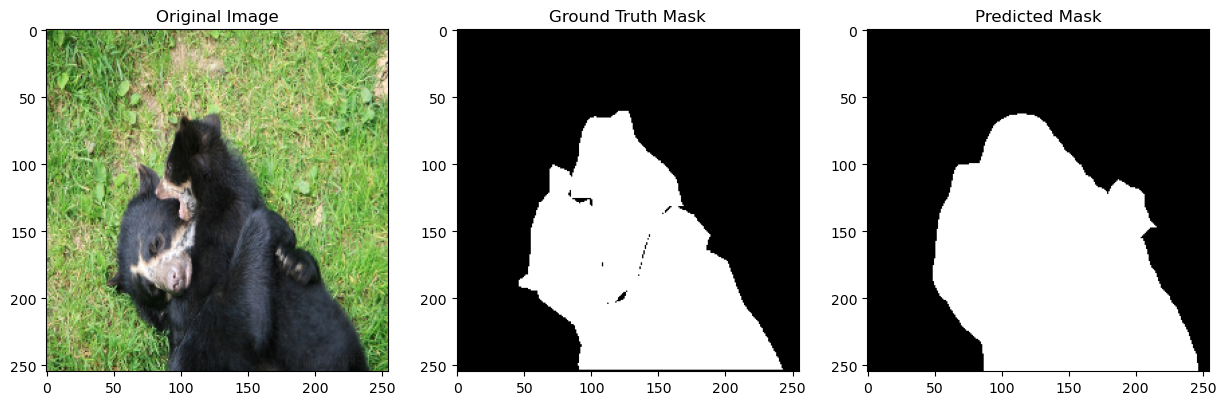

In [20]:
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)["out"]
        preds = torch.argmax(outputs, dim=1).cpu()

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(images[0].cpu().permute(1, 2, 0))
        ax[0].set_title("Original Image")
        ax[1].imshow(masks[0].cpu(), cmap="gray")
        ax[1].set_title("Ground Truth Mask")
        ax[2].imshow(preds[0], cmap="gray")
        ax[2].set_title("Predicted Mask")
        plt.show()
        break

In [21]:
def compute_metrics(outputs, masks, num_classes=2):
    """
    outputs: [N,H,W] predicted class ids
    masks:   [N,H,W] ground truth class ids
    """
    outputs = outputs.cpu().numpy()
    masks = masks.cpu().numpy()
    
    total_correct = 0
    total_pixels = 0
    iou_list = []

    for cls in range(num_classes):
        intersection = np.logical_and(outputs == cls, masks == cls).sum()
        union = np.logical_or(outputs == cls, masks == cls).sum()
        if union > 0:
            iou_list.append(intersection / union)

    total_correct += (outputs == masks).sum()
    total_pixels  += np.prod(masks.shape)

    overall_acc = total_correct / total_pixels
    mean_iou = np.mean(iou_list)

    return overall_acc, mean_iou

In [22]:
model.eval()
total_acc_sum = 0
miou_sum = 0
count = 0

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)["out"]
        preds = torch.argmax(outputs, dim=1)

        acc, miou = compute_metrics(preds, masks, num_classes=2)
        total_acc_sum += acc
        miou_sum += miou
        count += 1

pixel_acc = total_acc_sum / count
mean_iou  = miou_sum / count

In [23]:
print(f"Validation Pixel Accuracy: {pixel_acc:.4f}")
print(f"Validation Mean IoU: {mean_iou:.4f}")

Validation Pixel Accuracy: 0.9078
Validation Mean IoU: 0.7396
